In [1]:
#mount data from GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preface

Given a e-commerce Dataset. <br>
Business Demand: In order to define marketing goals, plan spending to lower
acquisition costs, <br> we want to know the revenue that customers can bring to our business in their lifetime. <br>

### Data preparation

Read dataframe using pandas, import necessary library for future use

In [3]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import datetime 
%matplotlib inline
data_path = '/content/drive/MyDrive/project_1_udacity_e-commerce.csv'
df = pd.read_csv(data_path, encoding= 'unicode_escape') 
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
523717,580519,22943,CHRISTMAS LIGHTS 10 VINTAGE BAUBLES,1,12/4/2011 14:51,10.79,NaN,United Kingdom
49228,540508,22726,ALARM CLOCK BAKELIKE GREEN,3,1/9/2011 11:20,3.75,14810.0,United Kingdom
139920,548367,85099F,JUMBO BAG STRAWBERRY,100,3/30/2011 15:51,1.65,17677.0,United Kingdom
316664,564755,23170,REGENCY TEA PLATE ROSES,1,8/30/2011 10:31,3.29,NaN,United Kingdom
467388,576339,84947,ANTIQUE SILVER TEA GLASS ENGRAVED,3,11/14/2011 15:27,2.46,14096.0,United Kingdom
365128,568697,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,36,9/28/2011 14:57,3.39,16281.0,United Kingdom
494296,578266,22279,POCKET BAG BLUE PAISLEY RED SPOT,5,11/23/2011 13:34,1.25,12748.0,United Kingdom
307646,563924,84792,ENCHANTED BIRD COATHANGER 5 HOOK,1,8/21/2011 14:32,4.65,15984.0,United Kingdom
432568,573876,23266,SET OF 3 WOODEN STOCKING DECORATION,2,11/1/2011 12:48,1.25,16360.0,United Kingdom
74753,542526,22241,GARLAND WOODEN HAPPY EASTER,12,1/28/2011 12:43,1.25,14659.0,United Kingdom


In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


We notice that:

1. Quantity and UnitPrice has min value lower than Zero. I will go deeper to find out later. It may caused by cancelled orders or kind of. 
2. Invoice and StockCode contain special character. We'll look into them to findout
3. There're anomalies in Quantity and UnitPrice. The min, max values in far away from the standard deviation. #TODO
4. There's some missing value from CustomerID



In [5]:
print (df.shape)
df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
missing_count = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / df.shape[0]
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'total_row' : df.shape[0],
                                 'unique_value': df.apply(lambda col: col.nunique()),
                                 'missing_count': missing_count,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,total_row,unique_value,missing_count,percent_missing
InvoiceNo,InvoiceNo,541909,25900,0,0.000000
StockCode,StockCode,541909,4070,0,0.000000
Quantity,Quantity,541909,722,0,0.000000
InvoiceDate,InvoiceDate,541909,23260,0,0.000000
UnitPrice,UnitPrice,541909,1630,0,0.000000
Country,Country,541909,38,0,0.000000
Description,Description,541909,4223,1454,0.268311
CustomerID,CustomerID,541909,4372,135080,24.926694


Note: <br>
4070 unique StockCode but 4223 unique Description => It might have multiple version of Product name, we should aware if working with Product name. <br> 
4372 CustomerID = 4372 Customers, compared to 541909 records. But we're missing 24.9% (135080 records) of customerID. I got 2 options for missing customerID: <br> 
1. Assume that each row which missing customerID as a new Customer -> assign them as a new CustomerID. In real life, we can use some Data Engineer techiques to acquire missing data in DataWarehouse or DataLake.
2. Consider to delete all missing data, because it affects to the buying history of customer if we can't assign to the right customer, it becomes bad data. Remember: Garbage In, Garbage Out.

We had 4372 customers and 135080 missing records, it will be weird if we assign 135080 new customers, this will make the data bias and unstable. So we should choose 2nd option with this dataset and this specific problem.

### Data Cleaning 

#### Basic cleaning

In [7]:
# First, remove rows which customeID is Null (mentioned before)
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
# Second, remove duplicates if there is any one
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)

5225


In [9]:
# Third, check all character in InvoiceNo & StockCode
### A function that list all non-digit in a string
all_char = []
import re

def find_character(pattern, invoice_no):
  for p in pattern:
    char = re.findall(p, invoice_no)
  return char
pattern = [r'\D+']
strg = 'C3343ddd50D'
print(find_character(pattern, strg))

['C', 'ddd', 'D']


In [10]:
### Check 
def find_char_in_column(column_name:str):
  all_char = []
  import re

  def find_character(pattern ,invoice_no):
    for p in pattern:
      char = re.findall(p, invoice_no)
      for ch in char:
        if ch not in all_char:
          all_char.append(ch)

  for i in range(df.shape[0]):
    strg = df[column_name].values[i]
    find_character([r'\D+'], strg)
  return all_char
print('All strange characters in InvoiceNo: ', find_char_in_column('InvoiceNo'))
print('All strange characters in StockCode: ', find_char_in_column('StockCode'))

All strange characters in InvoiceNo:  ['C']
All strange characters in StockCode:  ['A', 'B', 'G', 'E', 'POST', 'L', 'C', 'S', 'BL', 'N', 'D', 'F', 'T', 'H', 'M', 'R', 'K', 'P', 'V', 'J', 'W', 'BANK CHARGES', 'U', 'PADS', 'Y', 'I', 'DOT', 'CRUK', 'O', 'Z']


#### Special StockCode
  StockCode can include some special Character, but as we can see, There's some special word like 'POST', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK' <br> 
  Check that if there's any special STockcode that stand alone. <br>
  This should have some special meaning. Let's print out

In [11]:
# '^[a-zA-Z]' : match all strings that start with a letter
# '[^a-zA-Z]' : match all strings that contain a non-letter
# Normal StockCode Start with number, special StockCode start with Character
special_stockcodes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
print(special_stockcodes)
sample_df = df[df['StockCode'].isin(special_stockcodes)]
sample_df[['StockCode', 'Description']].drop_duplicates()

['POST' 'D' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT' 'CRUK']


,StockCode,Description
45,POST,POSTAGE
141,D,Discount
1423,C2,CARRIAGE
2239,M,Manual
4406,BANK CHARGES,Bank Charges
157195,PADS,PADS TO MATCH ALL CUSHIONS
317507,DOT,DOTCOM POSTAGE
317508,CRUK,CRUK Commission


So these transactions should represent for some extra Postages/Carriage/Charges from bank/extra pad as present/CRUK commission. Consider to drop cause it don't relate to order & customer behavior. These should belong to business side.

In [12]:
# Drop rows have StockCode in special_word
df = df[~df['StockCode'].isin(special_stockcodes)]

### Data Understanding, Data Featuring, Data Visualizing & Data Modeling

#### "C" pattern
Let's examine negative values to find out why and what's the reason of them. 

In [13]:
negative_df = df[(df['Quantity'] <0) | (df['UnitPrice'] <0)]
negative_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Assume that ALL InvoiceNo with the prefix 'C' is the sign of negative Orders. Let's check one more time.

In [14]:
invoiceNo_with_C = negative_df.loc[negative_df['InvoiceNo'].str.contains('C')]
print(f' Negative Quantity/UnitPrice Orders : {negative_df.shape[0]} rows\n',
      f'Negative Quantity/UnitPrice Orders with the C character in InvoiceNo : {invoiceNo_with_C.shape[0]} rows')
test_df = df.loc[df['InvoiceNo'].str.contains('C')]
print (f' All orders with the C character of InvoiceNo in whole dataset : {test_df.shape[0]} rows')

 Negative Quantity/UnitPrice Orders : 8506 rows
 Negative Quantity/UnitPrice Orders with the C character in InvoiceNo : 8506 rows
 All orders with the C character of InvoiceNo in whole dataset : 8506 rows


So we can conclude that 'C' stand for 'Cancelled'. So that, in order to measure how each customer contribute to the business, we have to minus all cancelled order.



My hypothesis: The InvoiceNo of canceled orders is added 'C' character from orginal InvoiceNo <br> 
Ex: Order invoiceNo 222222, if the customer cancel, the cancel invoiceNo should be C222222

In [15]:
import warnings 
warnings.filterwarnings('ignore')

def remove_c(s : str):
  return (s.replace('C', ''))
negative_df['InvoiceNo'] = negative_df['InvoiceNo'].apply(remove_c)
cancel_invoice = negative_df.InvoiceNo.drop_duplicates().to_list()
sample_df = df[df['InvoiceNo'].isin(cancel_invoice)]
sample_df.shape

(0, 8)

So my hypothesis is not correct. That mean the cancel order will generate new number with 'C' character. One possible method is groupby CustomerID and StockCode, which can be aggregated to identify the right quantity and total price of transaction with the business.

In [16]:
df.sort_values(by=['CustomerID', 'StockCode']).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
148306,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,2011-04-07 10:43:00,0.25,12347.0,Iceland
220583,556201,17021,NAMASTE SWAGAT INCENSE,36,2011-06-09 13:01:00,0.30,12347.0,Iceland
148289,549222,20665,RED RETROSPOT PURSE,6,2011-04-07 10:43:00,2.95,12347.0,Iceland


#### Process cancelled Order
We got 2 screnarios:
1.   Customer cancelled all items of an order
2.   Customer cancelled part of an order

What if we group Customer and StockCode, then sum the Quantity, it should solve that cancelled Products first, then aggregate it later.

In [18]:
# Count Possitive invoice of each customer.
sub_df = df[(df['Quantity'] >=0) & (df['UnitPrice'] >=0)][['CustomerID','InvoiceNo']] \
        .groupby('CustomerID').agg(totalInvoice=('InvoiceNo', lambda x: x.nunique()), \
                                   ).reset_index()
sub_df.head(5)

,CustomerID,totalInvoice
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


#### Plot Order by country

In [19]:
print('Number of customer :', sub_df.CustomerID.nunique())
print('Number of Invoice :', sub_df.totalInvoice.sum())
print('Average Invoice of each customer : {:.2f}'.format(sub_df.totalInvoice.sum()/sub_df.CustomerID.nunique()))

Number of customer : 4335
Number of Invoice : 18405
Average Invoice of each customer : 4.25


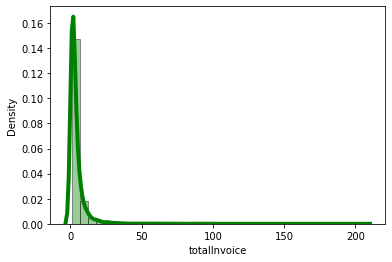

In [21]:
import seaborn as sns
sns.distplot(sub_df['totalInvoice'], hist=True, kde=True, \
             bins=36, color = 'green', \
             hist_kws={'edgecolor':'black'}, \
             kde_kws={'linewidth': 4})

In [23]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
aggregate_df = df.groupby(['CustomerID', 'StockCode', 'Country']).agg( \
                                                                  Quantities=('Quantity', 'sum'), \
                                                                  Prices=('TotalPrice', 'sum'), \
                                                                  EarliestDate=('InvoiceDate', 'min'), \
                                                                  LastestDate=('InvoiceDate', 'max') \
                                                                  ).reset_index().sort_values(by=['CustomerID', 'StockCode', 'Country'])
aggregate_df.head(5)

,CustomerID,StockCode,Country,Quantities,Prices,EarliestDate,LastestDate
0,12346.0,23166,United Kingdom,0,0.0,2011-01-18 10:01:00,2011-01-18 10:17:00
1,12347.0,16008,Iceland,24,6.0,2011-04-07 10:43:00,2011-04-07 10:43:00
2,12347.0,17021,Iceland,36,10.8,2011-06-09 13:01:00,2011-06-09 13:01:00
3,12347.0,20665,Iceland,6,17.7,2011-04-07 10:43:00,2011-04-07 10:43:00
4,12347.0,20719,Iceland,40,34.0,2011-01-26 14:30:00,2011-12-07 15:52:00


In [24]:
aggregate_df[aggregate_df['Prices'] <0].shape[0]

759

We see that there're quantities canceled is greater than the sum of the previous purchases. Or, some orders in the past do not show in this dataset. We can drop these negative orders, because it'll affect to the final result.

#### Modelling



**Purpose** <br>
In order to plan spending to lower acquisition costs,
we want to know the revenue that customers can bring to our business in their lifetime. <br>
To answer this question, with the data we got. I have 2 options to solve the problem. <br> 
1. Customer Segment to define group of customer, deeper analyst to know who they are, so we can pick the right marketing Strategy for them based on Purpose, how to acquire more people like them. With this dataframe, we can use KMean or SVC for customer segmentation
2. For a lifetime value, I recommend a RFM Model to evaluate Recency, Frequency, Monetary Value of each customer. With a new Marketing Goals demand, we can choose the right customer group for.

#### RFM

In [25]:
### RFM Calculation 
# Calculate M = Monetary Sum of all Paid Item
aggregate_df = aggregate_df[aggregate_df['Prices'] >=0]
customer = aggregate_df.groupby('CustomerID').agg(
                                                  totalItem=('Quantities', 'sum'),
                                                  totalPaid=('Prices', 'sum'),
                                                  EarliestInvoice=('EarliestDate', 'min'),
                                                  LastestInvoice=('LastestDate', 'max')
                                                  ).reset_index()

# Calculate F - Frequency by Merging with sub_df that count total Invoice purchased by customer
customer = customer.merge(sub_df, on='CustomerID', how='left')
customer['EarliestInvoice'] = pd.to_datetime(customer['EarliestInvoice'])
customer['LastestInvoice'] = pd.to_datetime(customer['LastestInvoice'])
# Get max of purchaseDate in dataset + 1 day
current_date = max(customer['LastestInvoice']) + datetime.timedelta(days=1)

# Calculate R - Recently
customer['mostRecent(days)'] = (current_date - customer['LastestInvoice']).dt.days
customer['EngagedAge(days)'] = (current_date - customer['EarliestInvoice']).dt.days

# Recency, Frequency and Monetary
customer.rename(columns={'mostRecent(days)':'Recency','totalInvoice':'Frequency','totalPaid':'Monetary'}, inplace=True)

customer.head(5)

,CustomerID,totalItem,Monetary,EarliestInvoice,LastestInvoice,Frequency,Recency,EngagedAge(days)
0,12346.0,0,0.00,2011-01-18 10:01:00,2011-01-18 10:17:00,1,326,326
1,12347.0,2458,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,7,2,367
2,12348.0,2332,1437.24,2010-12-16 19:09:00,2011-09-25 13:13:00,4,75,358
3,12349.0,630,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,19,19
4,12350.0,196,294.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,310,310


#### Distribution of Customer spending
Let's plot the price range to see the distribution of Customer spending

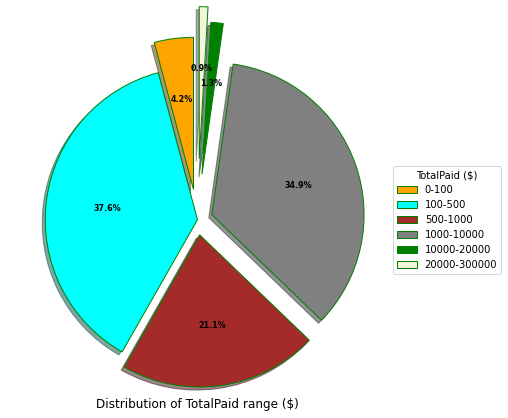

In [26]:
price_point = [0, 100, 500, 1000, 10000, 20000, 300000]
paid_range = []
count_range = []
for i, price in enumerate(price_point):
  if i == 0: 
    continue
  left = price_point[i-1]
  right = price_point[i]
  count = customer[(customer['Monetary'] >= left) & (customer['Monetary'] < right)]['Monetary'].count()
  count_range.append(count)
  paid_range.append(str(left) +'-' +str(right))

### Plot values
explode = (0.2, 0.0, 0.1, 0.1, 0.3, 0.4)
# Creating color parameters
colors = ('orange', 'cyan', 'brown',
          'grey', 'green', 'beige') 
# Wedge properties
wp = {'linewidth' : 1, 'edgecolor' : 'green' }
# Creating autocpt arguments
def func(pct, allvalues):
  return '{:.1f}%'.format(pct)
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(count_range,
                                  autopct = lambda pct: func(pct, count_range),
                                  explode = explode,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ='black'))
# Adding legend
ax.legend(wedges, paid_range,
          title ='TotalPaid ($)',
          loc ='center left',
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autotexts, size = 8, weight ='bold')
ax.set_title('Distribution of TotalPaid range ($)', y=-0.01)

plt.show()

As we can see, 93% of real puchased item is from 100-10000 <br>
4.2% go from range 0-100 <br>
2.2% customer spent over 20000 <br>
The porfolio is quite good.

#### Density

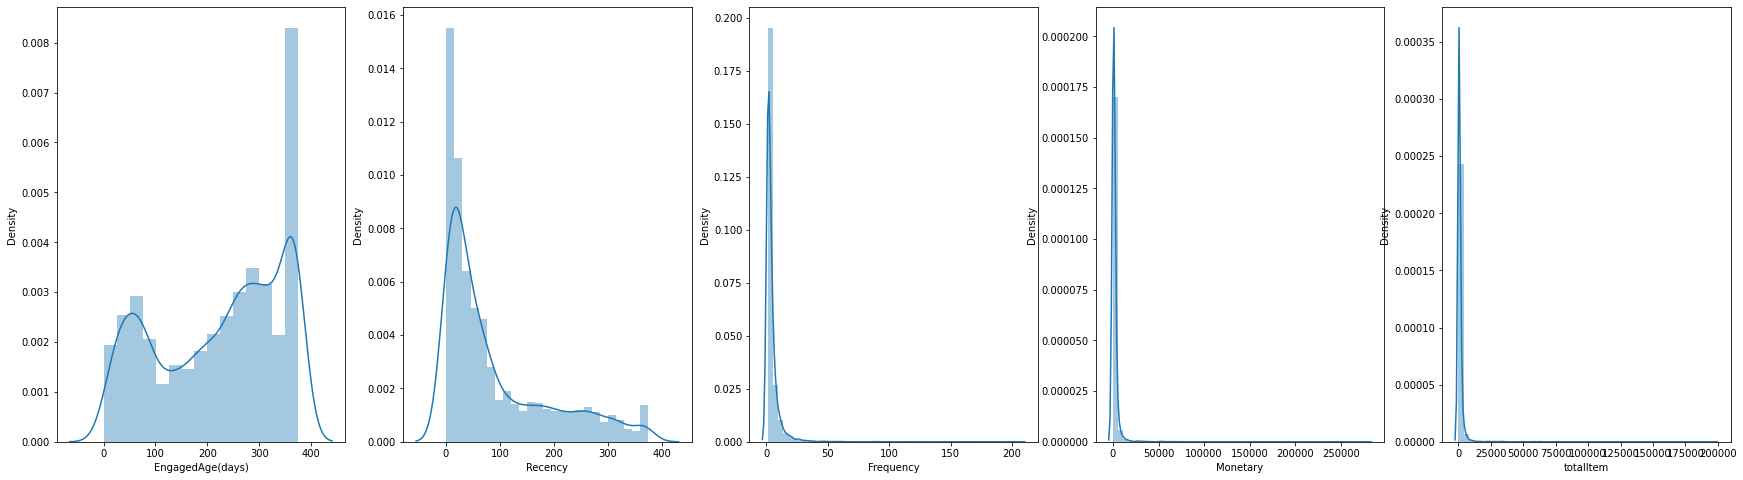

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(30,8))
sns.distplot(customer['EngagedAge(days)'], ax = ax[0])
sns.distplot(customer['Recency'], ax = ax[1])
sns.distplot(customer['Frequency'], ax = ax[2])
sns.distplot(customer['Monetary'], ax = ax[3])
sns.distplot(customer['totalItem'], ax = ax[4])

plt.show()

Look at the density plotting figures: 
* Data should have one year transaction, and a lot of customers have not bought any items for a long time.
* A high number of customer have not bought frequently.
* There're some strange orders with high value and number of items so that density is left-skewed

In [30]:
# Transform RFM Data 
from scipy import stats

df_customers = pd.DataFrame()
df_customers['Recency'] = stats.boxcox(customer['Recency'])[0]
df_customers['Frequency'] = stats.boxcox(customer['Frequency'])[0]
df_customers['Monetary'] = pd.Series(np.cbrt(customer['Monetary'])).values
df_customers.head(5)

,Recency,Frequency,Monetary
0,9.844488,0.000000,0.000000
1,0.735594,1.334009,16.273929
2,6.369953,1.053526,11.285213
3,3.820344,0.000000,11.338123
4,9.710598,0.000000,6.652414


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_customers)

df_customers = scaler.transform(df_customers)
pd.DataFrame(df_customers).head(5)

,0,1,2
0,1.623610,-1.179089,-2.018602
1,-1.800800,1.165609,1.361714
2,0.317389,0.672624,0.325490
3,-0.641114,-1.179089,0.336480
4,1.573276,-1.179089,-0.636805


#### KMean

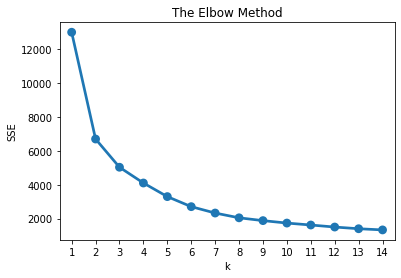

In [32]:
# Clustering using KMean
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Pick 4 is the number of cluster

In [33]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_customers)

KMeans(n_clusters=4, random_state=42)

In [34]:
customer['Cluster'] = model.labels_
customer.head(5)

,CustomerID,totalItem,Monetary,EarliestInvoice,LastestInvoice,Frequency,Recency,EngagedAge(days),Cluster
0,12346.0,0,0.00,2011-01-18 10:01:00,2011-01-18 10:17:00,1,326,326,1
1,12347.0,2458,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,7,2,367,0
2,12348.0,2332,1437.24,2010-12-16 19:09:00,2011-09-25 13:13:00,4,75,358,2
3,12349.0,630,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,19,19,3
4,12350.0,196,294.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,310,310,1


In [35]:
# Let's see common points of each group
customer.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,13.24,16.76,10785.24
1,222.87,1.43,418.12
2,40.66,4.83,1522.13
3,39.99,1.42,427.58


* Group 0 : Customers recently buy at high frequency and 
the amount buying is  amazing (average 10000) 
* Group 1 : Customers shopped for a long time, rarely shop with a decent amount, we shoud try to acquire these customer by trying to figure out why they churned
* Group 2 : Customers from last month, regularly and highly purchased. 
* Group 3 : Customers from last month, rarely and decent amount 

### Conclusion
This blog just show how to pre-process with E-commerce dataset, show one algorithm that help customer segementation for further use. With this Dataset, we can apply customer churn rate prediction/ detect factor that affect customer churning. Moreover, we can build a customer porfolio of a business to deeper understand our customer, therefore, build a suitable plan for acquiring new customer with same porfolio, retrieve current customer and build relationship with customer. 